https://github.com/tristandeleu/pytorch-meta/blob/master/examples/maml/train.py
https://github.com/learnables/learn2learn/blob/master/examples/vision/maml_miniimagenet.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
# os.environ['WANDB_MODE']='offline'
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

import albumentations as A
import monai

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import time
from collections import defaultdict
import copy
import gc

from utils.meta_dataset import EchoDataset_Meta_heatmap
from utils.train import *
from utils.evaluation import *
from utils.optimizer import *
from utils.utils import *

import wandb
import warnings
import learn2learn as l2l
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)

warnings.filterwarnings("ignore")


In [3]:
### Logging part
import logging
from datetime import datetime
from pytz import timezone
import sys

import random

def log(CFG):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    def timetz(*args):
        return datetime.now(tz).timetuple()
    tz = timezone('Asia/Seoul')
    logging.Formatter.converter = timetz

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # log 출력
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    # log를 파일에 출력
    file_handler = logging.FileHandler(os.path.join(CFG['save_path'], f"{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.log"))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info(f"python {' '.join(sys.argv)}")
    logger.info("Timezone: " + str(tz))
    logger.info(f"Training Start")
    return logger


In [4]:
def seed_everything(seed: int=0):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

## ⚙️ Configuration

In [5]:
view2cls_dict = {
    'PLAX': 3,
    'PSAX': 0,
    '2CH': 2,
    '4CH': 2,
}
class cfg:
    def __getitem__(self,key):
        return getattr(self, key)
    def __setitem__(self,key,value):
        return setattr(self, key, value)

    height = 256#480   
    width = 256#640
    view = 'PLAX'
    dataset = 'EchoNetLVH_datasetV2'
    lr = 5e-3
    scheduler = 'None'
    reducelr_factor = 0.99
    min_lr = 1e-5
    device = torch.device('mps')
    epochs = 50
    patience = 100
    batch_size = 16

    all_task_list = ['PLAX','PSAX','4CH', '2CH']
    meta_task_list = ['PLAX']#['PLAX','PSAX','4CH']

    ############## Meta Learing hyperparameter
    shot=20
    fast_lr = 0.01
    meta_batch_size=25, # num task, epoch ... 
    adaptation_steps=1,
    # num_iterations=60000,
    ############## Heatmap hyperparameter
    std = 15
    ##############
    model = 'UNet'
    backbone = 'resnet101'
    version = 'resnet101'
    
CFG = cfg()
CFG['save_path'] = os.path.join('saved_model', '_'.join([CFG['model'], CFG['version']]))
os.makedirs(CFG['save_path'], exist_ok=True)

In [6]:
# run = wandb.init(project='2022KOHI_keypoint_detection|Meta Learning',
#                 group=CFG['version'],
#                 name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}|CFG['version']",
#                 entity='kyh',
#                 # config={k:v for k, v in CFG.items() if '__' not in k}
#                 config={attr: CFG[attr] for attr in dir(CFG) if not callable(getattr(CFG, attr)) and not attr.startswith("__")},
#                 )

# model, hist = run_training(model=model.to(CFG["device"]),
#              train_ds=train_ds, 
#              val_ds=val_ds, 
#              optimizer=optimizer, 
#              scheduler=fetch_scheduler(CFG, optimizer), 
#              criterion=criterion, 
#              CFG=CFG,
#              wandb=wandb)
             
# wandb.run.finish()

In [7]:
logger = log(CFG)
trace_func = logger.info

2022-11-08 23:27:32,940 - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-47193e83-9305-47a7-9c4e-d4d7a18e11c1.json


2022-11-08 23:27:32,940 - root - INFO - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-47193e83-9305-47a7-9c4e-d4d7a18e11c1.json


2022-11-08 23:27:32,941 - Timezone: Asia/Seoul


2022-11-08 23:27:32,941 - root - INFO - Timezone: Asia/Seoul


2022-11-08 23:27:32,941 - Training Start


2022-11-08 23:27:32,941 - root - INFO - Training Start


In [8]:
dataset_dir = '../meta_dataset/' # 수정필요
CFG['dataset'] = dataset_dir.split('/')[-1]

## ⌗ Load Data

In [9]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class MinMaxNormalize(ImageOnlyTransform):
    """
    Min-max normalization
    """
    def apply(self, img, **param):
        # minmax normalize
        # img = (img - img.min()) / (img.max() - img.min())
        img = img / 255.
        return img
train_ts = A.Compose([
    A.Resize(CFG['height'], CFG['width']),
    MinMaxNormalize(p=1),

    ToTensorV2(),

],
    keypoint_params=A.KeypointParams(format='xy')
)
test_ts = A.Compose([
        A.Resize(CFG['height'], CFG['width']),
        MinMaxNormalize(p=1),
        ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format='xy')
        )


In [10]:
from utils.meta_dataset import EchoDataset_Meta_heatmap
train_ds = EchoDataset_Meta_heatmap(root=dataset_dir, 
                                    split='train', 
                                    shot=CFG['shot'],
                                    transforms=train_ts, 
                                    num_channels=3,
                                    task_list = ['PLAX', '4CH'])
val_ds = EchoDataset_Meta_heatmap(root=dataset_dir, 
                                  split='val', 
                                  shot=CFG['shot'],
                                  transforms=test_ts, 
                                  num_channels=3,
                                  task_list = ['PLAX','4CH'])#set(CFG['all_task_list']).difference(CFG['meta_task_list']))
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=False)


In [11]:
train_dl.dataset.__len__()

40

## Load Model

In [12]:
# https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name=CFG['backbone'],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    # encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization # 수정필요
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
    activation='softmax'
)

In [13]:
import learn2learn as l2l
model = l2l.algorithms.MAML(model, lr=CFG['fast_lr'], first_order=False)

In [14]:
from utils.loss import HeatmapMSELoss, HeatmapOHKMMSELoss, JointsRMSELoss
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG.lr)
criterion = HeatmapMSELoss(use_target_weight=False)

In [ ]:
from utils.heatmaps import *


def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]
    
    adaptation_labels = render_gaussian_dot_f(
                adaptation_labels.flip(dims=[2]), # xy 2 yx
                torch.tensor([CFG['std'], CFG['std']], dtype=torch.float32).to(CFG['device']),
                [CFG['height'], CFG['width']],
            ).to(torch.float)
    background = 1 - adaptation_labels.sum(dim=1).unsqueeze(1).clip(0,1)
    adaptation_labels = torch.concat((adaptation_labels,background), 1)

    evaluation_labels = render_gaussian_dot_f(
                evaluation_labels.flip(dims=[2]), # xy 2 yx
                torch.tensor([CFG['std'], CFG['std']], dtype=torch.float32).to(CFG['device']),
                [CFG['height'], CFG['width']],
            ).to(torch.float)
    background = 1 - evaluation_labels.sum(dim=1).unsqueeze(1).clip(0,1)
    evaluation_labels = torch.concat((evaluation_labels,background), 1)

    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)
    predictions = learner(evaluation_data)
    evaluation_error = loss(predictions, evaluation_labels)
    return evaluation_error

In [15]:
from utils.train_metalearning import train_one_epoch, valid_one_epoch
def run_training(model, train_ds, val_ds, optimizer, scheduler, criterion, CFG, wandb):
    """
    모델, 데이터를 받아 학습/검증 수행후 결과에 대해 출력 및 모델 저장
    """
    device = CFG['device']
    num_epochs = CFG['epochs']
    start = time.time()
    early_stopping = EarlyStopping(patience=CFG['patience'], verbose=True, trace_func=trace_func)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mde = np.inf
    best_metric_epoch = -1

    best_loss = np.inf
    best_loss_epoch = -1

    history = defaultdict(list)
    # 에폭만큼 학습 수행
    
    optimizer.zero_grad()
    train_dl = DataLoader(train_ds, batch_size=CFG['shot'], shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=CFG['shot'], shuffle=False)

    for epoch in range(1, num_epochs+1):
        del train_dl,val_dl
        gc.collect()
        train_ds.resample()
        val_ds.resample()
        model_ = model.clone()

        train_dl = DataLoader(train_ds, batch_size=CFG['shot']*2, shuffle=True)
        train_loss, train_mde, _ = train_one_epoch(model=model_, dataloader=train_dl, optimizer=optimizer, scheduler=scheduler, device=device, criterion=criterion, CFG=CFG)

        model_ = model.clone()
        val_dl = DataLoader(val_ds, batch_size=CFG['shot']*2, shuffle=False)
        val_loss, val_mde = valid_one_epoch(model=model_, dataloader=val_dl, device=device, criterion=criterion, CFG=CFG)
        early_stopping(val_loss, model)
        # for p in model.parameters():
        #     p.grad.data.mul_(1.0 / CFG['epochs'])
        optimizer.step()

        history['Train Loss'].append(train_loss)
        history['Train MDE'].append(train_mde)
        history['Valid Loss'].append(val_loss)
        history['Valid MDE'].append(val_mde)
        
        wandb.log({"Train Loss": train_loss, 
                "Train MDE": train_mde,
                "Valid Loss": val_loss,
                "Valid MDE": val_mde,
                "LR":scheduler.get_last_lr()[0] if CFG['scheduler'] != 'None' else optimizer.param_groups[0]['lr']
            }
            )

        trace_func(f"[Epoch {epoch}/{CFG['epochs']}: Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Train MDE: {train_mde:.5f}, Val MDE: {val_mde:.5f}")
        
        if scheduler is not None:
            scheduler.step()

        # Val MDE가 개선된 경우
        if val_mde <= best_mde:
            trace_func(f"Valid Score Improved ({best_mde:.4f} ---> {val_mde:.4f})")
            best_mde = val_mde
            best_metric_epoch = epoch
            best_metric_model_wts = copy.deepcopy(model.state_dict())
            
            wandb.run.summary['Best MDE'] = best_mde
            wandb.run.summary['Best Metric Epoch'] = best_metric_epoch

            model_name = f"best_metric_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde
                }, 
                os.path.join(CFG['save_path'], model_name))

            trace_func(f"Model Saved")

        # Loss 개선되었을때
        if val_loss <= best_loss:
            trace_func(f"Valid Loss Importved ({best_loss:.4f} ---> {val_loss:.4f})")
            best_loss = val_loss
            best_loss_epoch = epoch
            best_loss_model_wts = copy.deepcopy(model.state_dict())

            wandb.run.summary['Best MDE'] = best_mde
            wandb.run.summary['Best Loss Epoch'] = best_loss_epoch


            model_name = f"best_loss_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde
                }, 
                os.path.join(CFG['save_path'], model_name))

        if early_stopping.early_stop:
            trace_func("Early stopping")
            break

    model_name = f"last_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': val_loss,
                'metric': val_mde

                }, 
                os.path.join(CFG['save_path'], model_name))
    
    end = time.time()
    time_elapsed = end-start
    trace_func("Trianing complete in {:.0f}h {:.0f}m {:.0f}s".format(time_elapsed//3600, (time_elapsed%3600)//60, (time_elapsed%3600)%60))
    trace_func("Best Val MDE: {:.4f}".format(best_loss))
    trace_func("Best Val Loss: {:.4f}".format(best_mde))

    model.load_state_dict(best_metric_model_wts)

    return model, history

In [16]:
CFG['device'] = 'cpu'

## Train

In [17]:
run = wandb.init(project='2022KOHI_keypoint_detection|Meta Learning',
                group=CFG['version'],
                name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}|CFG['version']",
                entity='kyh',
                # config={k:v for k, v in CFG.items() if '__' not in k}
                config={attr: CFG[attr] for attr in dir(CFG) if not callable(getattr(CFG, attr)) and not attr.startswith("__")},
                )

model, hist = run_training(model=model.to(CFG["device"]),
             train_ds=train_ds, 
             val_ds=val_ds, 
             optimizer=optimizer, 
             scheduler=fetch_scheduler(CFG, optimizer), 
             criterion=criterion, 
             CFG=CFG,
             wandb=wandb)
             
wandb.run.finish()

2022-11-08 23:27:35,776 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


2022-11-08 23:27:35,776 - wandb.jupyter - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kyh. Use `wandb login --relogin` to force relogin


Valid : 100%|██████████| 1/1 [00:15<00:00, 15.26s/it, valid_MDE=72.5702, valid_loss=6486.4546]


2022-11-08 23:28:36,969 - Validation loss decreased (inf --> 6486.454590))#.  Saving model ...


2022-11-08 23:28:36,969 - root - INFO - Validation loss decreased (inf --> 6486.454590))#.  Saving model ...


2022-11-08 23:28:37,223 - [Epoch 1/50: Train Loss: 6464.18604, Val Loss: 6486.45459, Train MDE: 76.95414, Val MDE: 72.57016


2022-11-08 23:28:37,223 - root - INFO - [Epoch 1/50: Train Loss: 6464.18604, Val Loss: 6486.45459, Train MDE: 76.95414, Val MDE: 72.57016


2022-11-08 23:28:37,224 - Valid Score Improved (inf ---> 72.5702)


2022-11-08 23:28:37,224 - root - INFO - Valid Score Improved (inf ---> 72.5702)


2022-11-08 23:28:37,583 - Model Saved


2022-11-08 23:28:37,583 - root - INFO - Model Saved


2022-11-08 23:28:37,585 - Valid Loss Importved (inf ---> 6486.4546)


2022-11-08 23:28:37,585 - root - INFO - Valid Loss Importved (inf ---> 6486.4546)
Valid : 100%|██████████| 1/1 [00:12<00:00, 12.63s/it, valid_MDE=82.4841, valid_loss=4312.2021]


2022-11-08 23:29:37,063 - Validation loss decreased (6486.454590 --> 4312.202148))#.  Saving model ...


2022-11-08 23:29:37,063 - root - INFO - Validation loss decreased (6486.454590 --> 4312.202148))#.  Saving model ...


2022-11-08 23:29:37,661 - [Epoch 2/50: Train Loss: 4331.53418, Val Loss: 4312.20215, Train MDE: 78.92889, Val MDE: 82.48406


2022-11-08 23:29:37,661 - root - INFO - [Epoch 2/50: Train Loss: 4331.53418, Val Loss: 4312.20215, Train MDE: 78.92889, Val MDE: 82.48406


2022-11-08 23:29:37,663 - Valid Loss Importved (6486.4546 ---> 4312.2021)


2022-11-08 23:29:37,663 - root - INFO - Valid Loss Importved (6486.4546 ---> 4312.2021)
Valid : 100%|██████████| 1/1 [00:12<00:00, 12.75s/it, valid_MDE=77.2265, valid_loss=3427.5618]


2022-11-08 23:30:39,272 - Validation loss decreased (4312.202148 --> 3427.561768))#.  Saving model ...


2022-11-08 23:30:39,272 - root - INFO - Validation loss decreased (4312.202148 --> 3427.561768))#.  Saving model ...


2022-11-08 23:30:39,829 - [Epoch 3/50: Train Loss: 3353.62817, Val Loss: 3427.56177, Train MDE: 76.51026, Val MDE: 77.22646


2022-11-08 23:30:39,829 - root - INFO - [Epoch 3/50: Train Loss: 3353.62817, Val Loss: 3427.56177, Train MDE: 76.51026, Val MDE: 77.22646


2022-11-08 23:30:39,830 - Valid Loss Importved (4312.2021 ---> 3427.5618)


2022-11-08 23:30:39,830 - root - INFO - Valid Loss Importved (4312.2021 ---> 3427.5618)
Valid : 100%|██████████| 1/1 [00:13<00:00, 13.56s/it, valid_MDE=81.5384, valid_loss=2404.3235]


2022-11-08 23:31:41,310 - Validation loss decreased (3427.561768 --> 2404.323486))#.  Saving model ...


2022-11-08 23:31:41,310 - root - INFO - Validation loss decreased (3427.561768 --> 2404.323486))#.  Saving model ...


2022-11-08 23:31:41,917 - [Epoch 4/50: Train Loss: 2431.06592, Val Loss: 2404.32349, Train MDE: 83.57388, Val MDE: 81.53839


2022-11-08 23:31:41,917 - root - INFO - [Epoch 4/50: Train Loss: 2431.06592, Val Loss: 2404.32349, Train MDE: 83.57388, Val MDE: 81.53839


2022-11-08 23:31:41,919 - Valid Loss Importved (3427.5618 ---> 2404.3235)


2022-11-08 23:31:41,919 - root - INFO - Valid Loss Importved (3427.5618 ---> 2404.3235)
Valid : 100%|██████████| 1/1 [00:13<00:00, 13.45s/it, valid_MDE=88.1301, valid_loss=1793.7855]


2022-11-08 23:32:44,611 - Validation loss decreased (2404.323486 --> 1793.785522))#.  Saving model ...


2022-11-08 23:32:44,611 - root - INFO - Validation loss decreased (2404.323486 --> 1793.785522))#.  Saving model ...


2022-11-08 23:32:45,188 - [Epoch 5/50: Train Loss: 1813.84021, Val Loss: 1793.78552, Train MDE: 89.59572, Val MDE: 88.13010


2022-11-08 23:32:45,188 - root - INFO - [Epoch 5/50: Train Loss: 1813.84021, Val Loss: 1793.78552, Train MDE: 89.59572, Val MDE: 88.13010


2022-11-08 23:32:45,189 - Valid Loss Importved (2404.3235 ---> 1793.7855)


2022-11-08 23:32:45,189 - root - INFO - Valid Loss Importved (2404.3235 ---> 1793.7855)
Valid : 100%|██████████| 1/1 [00:13<00:00, 13.11s/it, valid_MDE=81.6805, valid_loss=1236.9338]


2022-11-08 23:33:44,843 - Validation loss decreased (1793.785522 --> 1236.933838))#.  Saving model ...


2022-11-08 23:33:44,843 - root - INFO - Validation loss decreased (1793.785522 --> 1236.933838))#.  Saving model ...


2022-11-08 23:33:45,319 - [Epoch 6/50: Train Loss: 1253.70300, Val Loss: 1236.93384, Train MDE: 79.81157, Val MDE: 81.68051


2022-11-08 23:33:45,319 - root - INFO - [Epoch 6/50: Train Loss: 1253.70300, Val Loss: 1236.93384, Train MDE: 79.81157, Val MDE: 81.68051


2022-11-08 23:33:45,320 - Valid Loss Importved (1793.7855 ---> 1236.9338)


2022-11-08 23:33:45,320 - root - INFO - Valid Loss Importved (1793.7855 ---> 1236.9338)
Valid : 100%|██████████| 1/1 [00:13<00:00, 13.65s/it, valid_MDE=103.7163, valid_loss=974.6797]


2022-11-08 23:34:46,120 - Validation loss decreased (1236.933838 --> 974.679688))#.  Saving model ...


2022-11-08 23:34:46,120 - root - INFO - Validation loss decreased (1236.933838 --> 974.679688))#.  Saving model ...


2022-11-08 23:34:46,740 - [Epoch 7/50: Train Loss: 971.32550, Val Loss: 974.67969, Train MDE: 96.38546, Val MDE: 103.71630


2022-11-08 23:34:46,740 - root - INFO - [Epoch 7/50: Train Loss: 971.32550, Val Loss: 974.67969, Train MDE: 96.38546, Val MDE: 103.71630


2022-11-08 23:34:46,742 - Valid Loss Importved (1236.9338 ---> 974.6797)


2022-11-08 23:34:46,742 - root - INFO - Valid Loss Importved (1236.9338 ---> 974.6797)
Valid : 100%|██████████| 1/1 [00:12<00:00, 12.77s/it, valid_MDE=112.9931, valid_loss=756.2965]


2022-11-08 23:35:47,878 - Validation loss decreased (974.679688 --> 756.296509))#.  Saving model ...


2022-11-08 23:35:47,878 - root - INFO - Validation loss decreased (974.679688 --> 756.296509))#.  Saving model ...


2022-11-08 23:35:48,391 - [Epoch 8/50: Train Loss: 784.45990, Val Loss: 756.29651, Train MDE: 112.86645, Val MDE: 112.99309


2022-11-08 23:35:48,391 - root - INFO - [Epoch 8/50: Train Loss: 784.45990, Val Loss: 756.29651, Train MDE: 112.86645, Val MDE: 112.99309


2022-11-08 23:35:48,392 - Valid Loss Importved (974.6797 ---> 756.2965)


2022-11-08 23:35:48,392 - root - INFO - Valid Loss Importved (974.6797 ---> 756.2965)
Valid : 100%|██████████| 1/1 [00:12<00:00, 12.40s/it, valid_MDE=120.6322, valid_loss=610.0218]


2022-11-08 23:36:48,199 - Validation loss decreased (756.296509 --> 610.021790))#.  Saving model ...


2022-11-08 23:36:48,199 - root - INFO - Validation loss decreased (756.296509 --> 610.021790))#.  Saving model ...


2022-11-08 23:36:48,745 - [Epoch 9/50: Train Loss: 609.01453, Val Loss: 610.02179, Train MDE: 120.18346, Val MDE: 120.63218


2022-11-08 23:36:48,745 - root - INFO - [Epoch 9/50: Train Loss: 609.01453, Val Loss: 610.02179, Train MDE: 120.18346, Val MDE: 120.63218


2022-11-08 23:36:48,746 - Valid Loss Importved (756.2965 ---> 610.0218)


2022-11-08 23:36:48,746 - root - INFO - Valid Loss Importved (756.2965 ---> 610.0218)
Valid : 100%|██████████| 1/1 [00:13<00:00, 13.41s/it, valid_MDE=128.0168, valid_loss=567.1100]


2022-11-08 23:37:50,065 - Validation loss decreased (610.021790 --> 567.109985))#.  Saving model ...


2022-11-08 23:37:50,065 - root - INFO - Validation loss decreased (610.021790 --> 567.109985))#.  Saving model ...


2022-11-08 23:37:50,666 - [Epoch 10/50: Train Loss: 562.61029, Val Loss: 567.10999, Train MDE: 128.14234, Val MDE: 128.01681


2022-11-08 23:37:50,666 - root - INFO - [Epoch 10/50: Train Loss: 562.61029, Val Loss: 567.10999, Train MDE: 128.14234, Val MDE: 128.01681


2022-11-08 23:37:50,668 - Valid Loss Importved (610.0218 ---> 567.1100)


2022-11-08 23:37:50,668 - root - INFO - Valid Loss Importved (610.0218 ---> 567.1100)
Valid : 100%|██████████| 1/1 [00:12<00:00, 12.54s/it, valid_MDE=130.2652, valid_loss=568.2789]


2022-11-08 23:38:49,756 - EarlyStopping counter: 1 out of 100


2022-11-08 23:38:49,756 - root - INFO - EarlyStopping counter: 1 out of 100


2022-11-08 23:38:50,259 - [Epoch 11/50: Train Loss: 575.09161, Val Loss: 568.27893, Train MDE: 131.23349, Val MDE: 130.26525


2022-11-08 23:38:50,259 - root - INFO - [Epoch 11/50: Train Loss: 575.09161, Val Loss: 568.27893, Train MDE: 131.23349, Val MDE: 130.26525
Valid : 100%|██████████| 1/1 [00:12<00:00, 12.74s/it, valid_MDE=130.9591, valid_loss=583.7701]


2022-11-08 23:39:49,435 - EarlyStopping counter: 2 out of 100


2022-11-08 23:39:49,435 - root - INFO - EarlyStopping counter: 2 out of 100


2022-11-08 23:39:49,919 - [Epoch 12/50: Train Loss: 583.70959, Val Loss: 583.77008, Train MDE: 130.15839, Val MDE: 130.95911


2022-11-08 23:39:49,919 - root - INFO - [Epoch 12/50: Train Loss: 583.70959, Val Loss: 583.77008, Train MDE: 130.15839, Val MDE: 130.95911
Valid : 100%|██████████| 1/1 [00:10<00:00, 10.75s/it, valid_MDE=128.7984, valid_loss=590.7570]


2022-11-08 23:40:44,871 - EarlyStopping counter: 3 out of 100


2022-11-08 23:40:44,871 - root - INFO - EarlyStopping counter: 3 out of 100


2022-11-08 23:40:45,220 - [Epoch 13/50: Train Loss: 589.13312, Val Loss: 590.75702, Train MDE: 127.59004, Val MDE: 128.79842


2022-11-08 23:40:45,220 - root - INFO - [Epoch 13/50: Train Loss: 589.13312, Val Loss: 590.75702, Train MDE: 127.59004, Val MDE: 128.79842
Valid : 100%|██████████| 1/1 [00:11<00:00, 11.31s/it, valid_MDE=126.1594, valid_loss=592.9287]


2022-11-08 23:41:39,348 - EarlyStopping counter: 4 out of 100


2022-11-08 23:41:39,348 - root - INFO - EarlyStopping counter: 4 out of 100


2022-11-08 23:41:39,693 - [Epoch 14/50: Train Loss: 594.52472, Val Loss: 592.92871, Train MDE: 126.89850, Val MDE: 126.15938


2022-11-08 23:41:39,693 - root - INFO - [Epoch 14/50: Train Loss: 594.52472, Val Loss: 592.92871, Train MDE: 126.89850, Val MDE: 126.15938
Valid : 100%|██████████| 1/1 [00:10<00:00, 10.82s/it, valid_MDE=118.6323, valid_loss=596.5627]


2022-11-08 23:42:33,466 - EarlyStopping counter: 5 out of 100


2022-11-08 23:42:33,466 - root - INFO - EarlyStopping counter: 5 out of 100


2022-11-08 23:42:33,838 - [Epoch 15/50: Train Loss: 599.05109, Val Loss: 596.56268, Train MDE: 118.62052, Val MDE: 118.63231


2022-11-08 23:42:33,838 - root - INFO - [Epoch 15/50: Train Loss: 599.05109, Val Loss: 596.56268, Train MDE: 118.62052, Val MDE: 118.63231
Valid : 100%|██████████| 1/1 [00:12<00:00, 12.13s/it, valid_MDE=116.6318, valid_loss=601.6141]


2022-11-08 23:43:30,876 - EarlyStopping counter: 6 out of 100


2022-11-08 23:43:30,876 - root - INFO - EarlyStopping counter: 6 out of 100


2022-11-08 23:43:31,339 - [Epoch 16/50: Train Loss: 601.44971, Val Loss: 601.61407, Train MDE: 117.99830, Val MDE: 116.63179


2022-11-08 23:43:31,339 - root - INFO - [Epoch 16/50: Train Loss: 601.44971, Val Loss: 601.61407, Train MDE: 117.99830, Val MDE: 116.63179
Train :   0%|          | 0/1 [00:00<?, ?it/s]

## test

In [ ]:
val_it = train_dl.__iter__()

In [ ]:
val_elem = val_it.next()

In [ ]:
# model.eval()
result = model.to(torch.device('cpu'))(val_elem['data'])

In [ ]:
from utils.heatmaps import *
heatmap = render_gaussian_dot_f(
    val_elem['label'][0:1].flip(dims=[2]), # xy 2 yx
    torch.tensor([CFG['std'], CFG['std']], dtype=torch.float32).to('cpu'),
    [CFG['height'], CFG['width']],
    # mul=255.
    )


In [ ]:
x = val_elem['label'].squeeze()

(-0.5, 255.5, 255.5, -0.5)

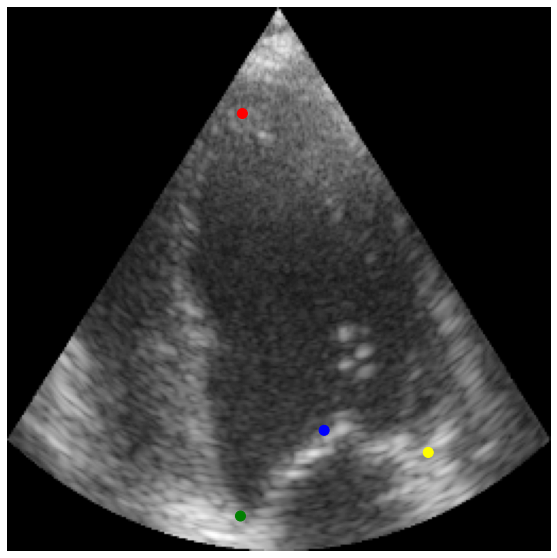

In [ ]:
plt.figure(figsize=(15,10))

plt.imshow(val_elem['data'][0,0,...].numpy(), cmap='gray')
plt.scatter(x[0][:,0], x[0][:,1], c=['red', 'blue', 'green', 'yellow'], s=100)
plt.axis('off')

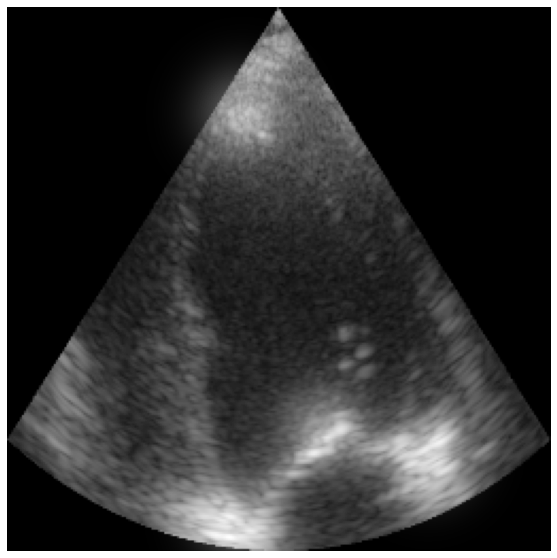

In [ ]:
import cv2
i = cv2.addWeighted(val_elem['data'][0,0,...].numpy(),1,heatmap.squeeze().sum(0).numpy(),.5,0)

plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(i, cmap='gray')

In [ ]:
background = 1 - heatmap.sum(dim=1).unsqueeze(1).clip(0,1)
heatmap = torch.concat((heatmap,background), 1)

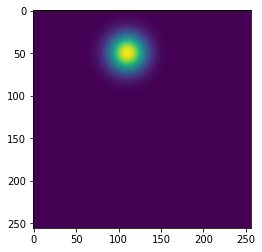

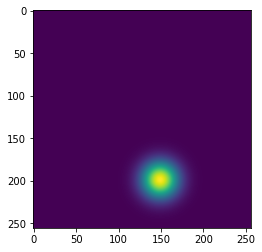

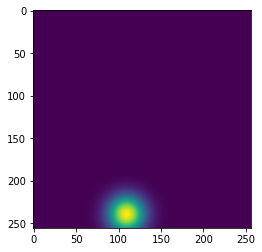

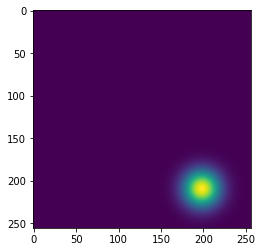

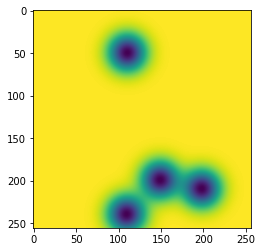

In [ ]:
for i in heatmap.squeeze():
    plt.imshow(i)
    plt.show()
    # print((i==i.max()).nonzero())

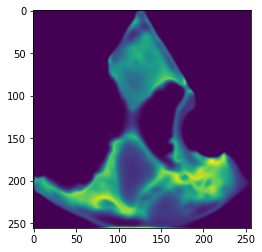

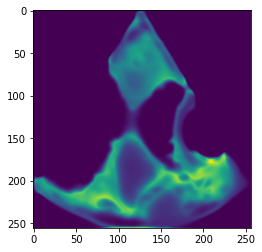

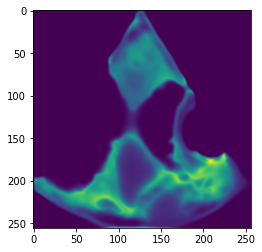

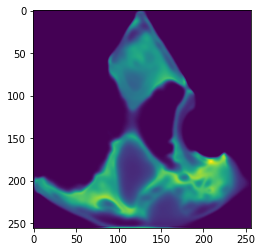

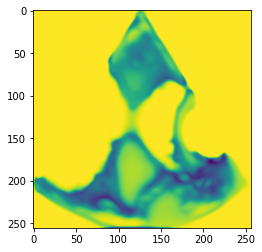

In [ ]:
predicted = []
for i in result[0].squeeze():
    a = i.detach().clone().numpy()
    # print(a)
    # a[a<=.3]=0
    
    plt.imshow(a)
    plt.show()
    predicted.append((a==a.max()).nonzero())
